In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class ISM_Model:
    def __init__(self, adjacency_matrix, element_names=None):
        """
        初始化ISM模型
        :param adjacency_matrix: 邻接矩阵 (2D list or numpy array)
        :param element_names: 元素名称列表 (可选)
        """
        self.adj_mat = np.array(adjacency_matrix)
        self.n = self.adj_mat.shape[0]  # 元素个数
        
        # 如果没有提供元素名称，则用数字编号
        if element_names is None:
            self.element_names = [f'E{i+1}' for i in range(self.n)]
        else:
            self.element_names = element_names
            
        # 初始化其他属性
        self.reachability_mat = None
        self.levels = {}  # 存储层级划分结果 {层级: [元素索引]}
        self.hierarchy_graph = None
        
    def compute_reachability_matrix(self):
        """计算可达矩阵（使用Warshall算法）"""
        print("=== 开始计算可达矩阵 ===")
        # 初始化可达矩阵（单位矩阵 + 邻接矩阵）
        R = np.identity(self.n, dtype=int) | self.adj_mat  # 每个元素自身可达
        
        print("初始可达矩阵 (R? = I ∪ A):")
        self._print_matrix(R)
        
        # Warshall算法计算传递闭包
        for k in range(self.n):
            print(f"\n--- 迭代 k = {k+1} (经过元素 {self.element_names[k]}) ---")
            # R^{k+1}[i, j] = R^k[i, j] OR (R^k[i, k] AND R^k[k, j])
            for i in range(self.n):
                for j in range(self.n):
                    if R[i, j] == 0:
                        R[i, j] = R[i, k] and R[k, j]
            
            print(f"更新后的可达矩阵 R^{k+1}:")
            self._print_matrix(R)
        
        self.reachability_mat = R
        print("\n=== 最终可达矩阵 ===")
        self._print_matrix(self.reachability_mat)
        return R
    
    def _print_matrix(self, matrix):
        """辅助函数：漂亮地打印矩阵"""
        print('    ' + ' '.join(f'{name:>4}' for name in self.element_names))
        for i, row in enumerate(matrix):
            print(f'{self.element_names[i]:>4}' + ''.join(f'{val:>5}' for val in row))
    
    def _set_to_names(self, index_set):
        """将索引集合转换为元素名称集合"""
        return {self.element_names[i] for i in index_set}
    
    def build_hierarchy_graph(self):
        """构建层级图"""
        print("\n=== 构建层级图 ===")
        G = nx.DiGraph()
        
        # 添加节点和层级属性
        for level, elements in self.levels.items():
            for elem_idx in elements:
                G.add_node(self.element_names[elem_idx], level=level)
        
        # 添加边（基于原始邻接矩阵）
        for i in range(self.n):
            for j in range(self.n):
                if self.adj_mat[i, j] == 1 and i != j:
                    G.add_edge(self.element_names[i], self.element_names[j])
        
        self.hierarchy_graph = G
        return G
        
    def level_partitioning(self):
        print("\n" + "="*50)
        print("开始层级划分过程")
        print("="*50)
        
        unassigned = set(range(self.n))
        current_level = 1
        
        while unassigned:
            print(f"\n--- 寻找第 {current_level} 层元素 ---")
            level_elements = []
            
            # 每次循环都重新计算当前剩余元素的可达集和先行集
            reach_sets = {}
            antecedent_sets = {}
            
            # 只计算未分配元素的可达集和先行集，并且只考虑未分配元素
            for i in unassigned:
                # 可达集: 元素i可达的所有未分配元素
                reachable_indices = np.where(self.reachability_mat[i] == 1)[0]
                reach_sets[i] = set(idx for idx in reachable_indices if idx in unassigned)
                
                # 先行集: 所有可达元素i的未分配元素
                antecedent_indices = np.where(self.reachability_mat[:, i] == 1)[0]
                antecedent_sets[i] = set(idx for idx in antecedent_indices if idx in unassigned)
            
            for i in list(unassigned):
                # 计算共同集 C(i) = R(i) ∩ A(i)
                common_set = reach_sets[i] & antecedent_sets[i]
                
                print(f"元素 {self.element_names[i]}:")
                print(f"  可达集 R({self.element_names[i]}) = {self._set_to_names(reach_sets[i])}")
                print(f"  先行集 A({self.element_names[i]}) = {self._set_to_names(antecedent_sets[i])}")
                print(f"  共同集 C({self.element_names[i]}) = {self._set_to_names(common_set)}")
                
                # 判断条件: C(i) == R(i)
                if common_set == reach_sets[i]:
                    level_elements.append(i)
                    print(f"  判断: C({self.element_names[i]}) == R({self.element_names[i]}) → 属于第 {current_level} 层")
                else:
                    print(f"  判断: C({self.element_names[i]}) != R({self.element_names[i]}) → 不属于当前层")
            
            if not level_elements:
                print("警告: 未找到当前层元素，但仍有未分配元素。可能存在循环关系！")
                break
            
            self.levels[current_level] = level_elements
            print(f"\n第 {current_level} 层元素: {self._set_to_names(level_elements)}")
            
            unassigned -= set(level_elements)
            current_level += 1
        
        print("\n=== 层级划分完成 ===")
        for level, elements in self.levels.items():
            print(f"层级 {level}: {self._set_to_names(elements)}")
        
        return self.levels

    def plot_hierarchy(self, save_path=None):
        """绘制层级图并显示因果关系"""
        if self.hierarchy_graph is None:
            self.build_hierarchy_graph()
        
        G = self.hierarchy_graph
        
        # 设置中文字体支持
        plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'sans-serif']
        plt.rcParams['axes.unicode_minus'] = False
        
        # 创建布局 - 按层级排列节点
        pos = {}
        max_level = max(self.levels.keys())
        
        # 为每个层级分配y坐标（顶层在顶部）
        for level, elements in self.levels.items():
            # 反转层级：最顶层在y=0，最底层在y=max_level
            y = max_level - level
            
            # 水平排列同一层级的节点
            num_nodes = len(elements)
            for i, elem_idx in enumerate(elements):
                elem_name = self.element_names[elem_idx]
                # 水平居中排列
                x = (i - num_nodes/2) * 1.5
                pos[elem_name] = (x, y)
        
        # 绘制图形
        plt.figure(figsize=(10, 8))
        
        # 绘制节点
        node_colors = []
        for node in G.nodes():
            level = G.nodes[node]['level']
            # 不同层级使用不同颜色
            if level == 1:
                node_colors.append('lightcoral')  # 底层 - 红色系
            elif level == max_level:
                node_colors.append('lightgreen')  # 顶层 - 绿色系
            else:
                node_colors.append('lightblue')   # 中间层 - 蓝色系
        
        nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors, alpha=0.8)
        
        # 绘制边
        nx.draw_networkx_edges(
            G, pos, 
            edge_color='gray', 
            width=1.5, 
            arrowstyle='->', 
            arrowsize=20
        )
        
        # 绘制节点标签
        nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
        
        # 绘制边标签（显示关系）
        edge_labels = {}
        for i in range(self.n):
            for j in range(self.n):
                if self.adj_mat[i, j] == 1 and i != j:
                    source = self.element_names[i]
                    target = self.element_names[j]
                    edge_labels[(source, target)] = f"{source}→{target}"
        
        nx.draw_networkx_edge_labels(
            G, pos, 
            edge_labels=edge_labels,
            font_color='darkred',
            font_size=20
        )
        
        # 添加层级说明
        for level in range(1, max_level + 1):
            plt.text(
                -5, max_level - level, 
                f"层级 {level}", 
                fontsize=12, 
                color='darkblue',
                verticalalignment='center'
            )
        
        plt.title("ISM 层级结构图", fontsize=16)
        plt.axis('off')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"层级图已保存至: {save_path}")
        
        plt.show()

=== 开始计算可达矩阵 ===
初始可达矩阵 (R? = I ∪ A):
      E1   E2   E3   E4   E5
  E1    1    1    1    0    0
  E2    0    1    0    1    0
  E3    0    0    1    0    1
  E4    0    0    0    1    0
  E5    0    0    0    0    1

--- 迭代 k = 1 (经过元素 E1) ---
更新后的可达矩阵 R^1:
      E1   E2   E3   E4   E5
  E1    1    1    1    0    0
  E2    0    1    0    1    0
  E3    0    0    1    0    1
  E4    0    0    0    1    0
  E5    0    0    0    0    1

--- 迭代 k = 2 (经过元素 E2) ---
更新后的可达矩阵 R^2:
      E1   E2   E3   E4   E5
  E1    1    1    1    1    0
  E2    0    1    0    1    0
  E3    0    0    1    0    1
  E4    0    0    0    1    0
  E5    0    0    0    0    1

--- 迭代 k = 3 (经过元素 E3) ---
更新后的可达矩阵 R^3:
      E1   E2   E3   E4   E5
  E1    1    1    1    1    1
  E2    0    1    0    1    0
  E3    0    0    1    0    1
  E4    0    0    0    1    0
  E5    0    0    0    0    1

--- 迭代 k = 4 (经过元素 E4) ---
更新后的可达矩阵 R^4:
      E1   E2   E3   E4   E5
  E1    1    1    1    1    1
  E2    0    1    0

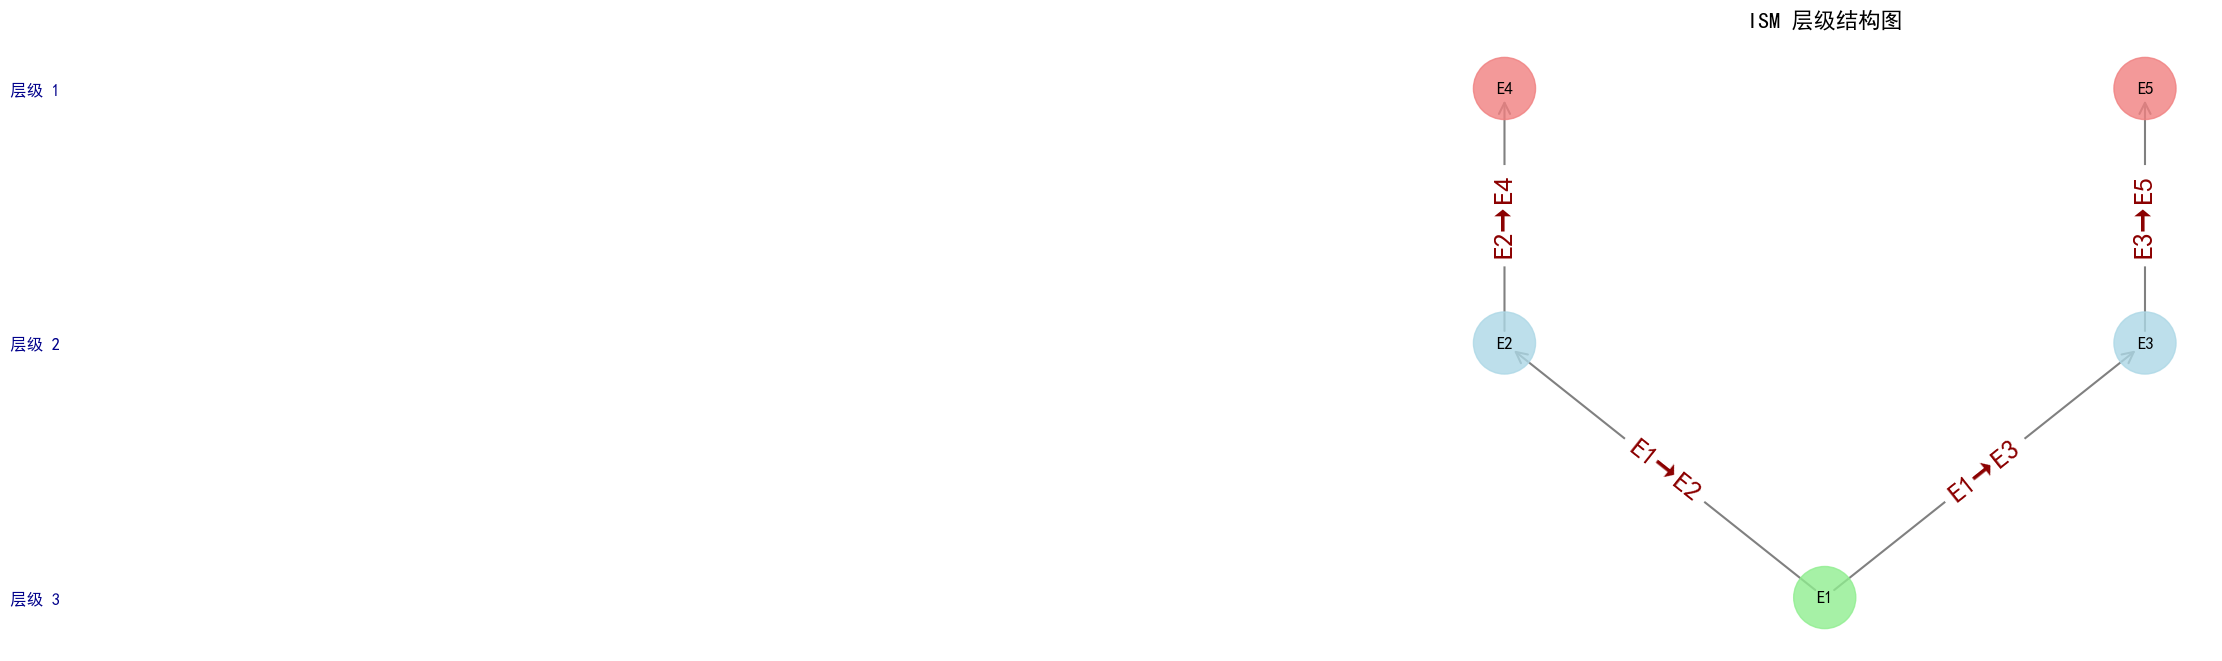

In [2]:
# 示例邻接矩阵 (A->B 表示 A 影响 B)
# 这里用一个简单的 5元素示例
adj_matrix = [
    [1, 1, 1, 0, 0],  # E1->E2, E1->E3
    [0, 1, 0, 1, 0],  # E2->E4
    [0, 0, 1, 0, 1],  # E3->E5
    [0, 0, 0, 1, 0],  # E4不影响任何元素
    [0, 0, 0, 0, 1]   # E5不影响任何元素
]
elements = ['E1', 'E2', 'E3', 'E4', 'E5']

# 创建ISM模型实例
ism = ISM_Model(adj_matrix, elements)

# 1. 计算可达矩阵
ism.compute_reachability_matrix()

# 2. 进行层级划分
ism.level_partitioning()

# 3. 构建层级图
ism.build_hierarchy_graph()

# 4. 绘制层级图
ism.plot_hierarchy(save_path="ism_hierarchy.png")